In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
words = open('names.txt', 'r').read().splitlines()

In [17]:
# define stoi 
stoi = {}
allletters = sorted(set("".join(words)))

stoi = {s:i+1 for i,s in enumerate(allletters)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

In [18]:
# dataset preparation 

X , Y = [], []
block_size= 3 # can be reset to whatever you like

for w in words:
    context = [0]*block_size # contains indcies of context letters
    for ch in w + '.':
        ix = stoi[ch]
        Y.append(ix) 
        X.append(context)
        context = context[1:] + [ix] # update context and append new index

X = torch.tensor(X)
Y = torch.tensor(Y)


In [27]:
g = torch.Generator().manual_seed(214748367)
# lookup matrix
C = torch.randn((27,2), generator=g)
# hidden layer - 100 neurons
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn((100,), generator=g)
# Output layer
W2 = torch.randn((100,27), generator=g )
b2 = torch.randn((27,), generator=g)

parameters = [C, W1, b1, W2, b2]

In [28]:
sum(p.nelement() for p in parameters) # total no of parameters in the network

3481

In [29]:
for p in parameters:
    p.requires_grad = True

Instead of training on entire dataset, lets run it on batches of size 32 each to make the training faster. 

modifications: $X\rightarrow X[ix]$, $Y\rightarrow Y[ix]$

__Consequences:__
- This will introduce some stochasticity and loss will not decrease uniformly. 
- The learning rate is a hyperparameter which we will tune. 
- Overall the time required to run batches will be much faster 
- Convergence to a loss may be slower and random

In [103]:
for  iter in range(30):

    ix = torch.randint(0, X.shape[0], (32,)) # assuming each batch has 32 data points 
    # Forward pass: 
    emb = C[X[ix]]
    H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # 32,100
    logits = H @ W2 + b2
    loss = F.cross_entropy(logits, target=Y[ix])
    # Back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad
    
print(loss.item())

2.6578099727630615


In [105]:
emb.shape

torch.Size([32, 3, 2])

Loss on full testset after minibatch GD:

In [22]:
# To the function more precise, can include W,b as arguments as well
def loss_fullset(A):
    emb_fullset = C[A] # 228146,3,2
    H = torch.tanh(emb_fullset.view(-1, 6) @ W1 + b1) # 228146,6 @ 6,100 => 228146, 100
    logits_fullset = H @ W2 + b2
    loss_fullset = F.cross_entropy(logits_fullset, target=Y)
    return loss_fullset

loss_fullset(X)

tensor(18.4338, grad_fn=<NllLossBackward0>)

Hence: using the parameters learnt from mini batchGD, loss on entire set is `2.8780`, which is not very far from the 2.5-3.0 range loss on the training batches. 

### Manual tuning for step size $\alpha$
One issue is that we don't know whether magnitude of step size $\alpha$ is too high or too low. Try $\alpha = [0.0001, 0.001, 0.01. 0.1, 1, 10]$ see at what values the loss explodes or becomes unstable and set them as limits. Refine iteratively. 

For our problem, $0.001 = 10^{-3}$ and $1 = 10^{0}$ prove to be good limits on $\alpha$. 

In [30]:
lre = torch.linspace(-3,0,1000) # 1000 exponents
lrs = 10**lre # list of learning rates 

__NOTE:__ rerun the cells where W,b,C are initialized and p.grad = True is set. 

In [31]:
lri = []
lossi = []
loss_full = []

for iter in range(1000): 
    # 1000 mini batches of size 32 each 
    ix = torch.randint(0, X.shape[0], (32,)) # assuming each batch has 32 data points 
    # Forward pass: 
    emb = C[X[ix]]
    H = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1) # 32,100
    logits = H @ W2 + b2
    loss = F.cross_entropy(logits, target=Y[ix])
    # Back pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[iter]
    for p in parameters:
        p.data -= lr * p.grad
    # track loss
    lossi.append(loss.item())
    lri.append(lr)
    
    

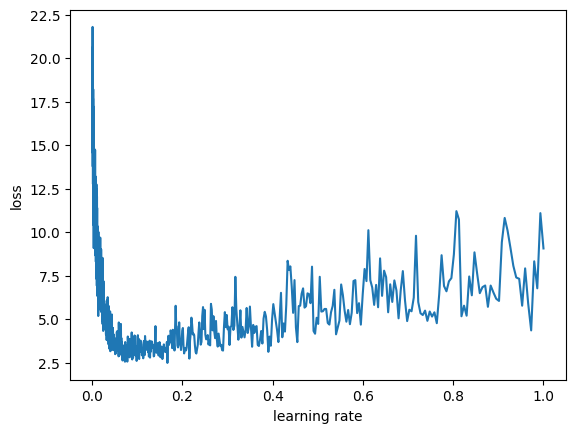

In [32]:
plt.plot(lri, lossi)
# plt.plot(lri, loss_full)
# plt.legend(title = "loss variation", loc = 'lower left')
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.show()

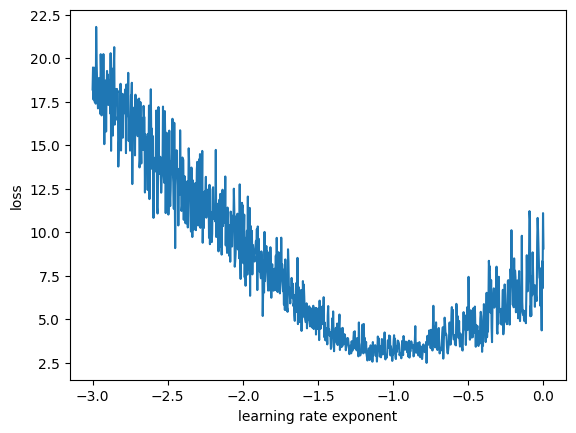

In [33]:
plt.plot(lre, lossi)
plt.xlabel('learning rate exponent')
plt.ylabel('loss')
plt.show()

From the two figures it is evident that least _training __batch__ loss_ is obtained somewhere around lr = $10^{-1}$ or lr = $0.1$

So you can run like 1000 iterations, 3 times for lr = $0.1$ then 3 more times for lr = $0.01$ and so on untill loss absolutely plateaus or set a custom termination criteria. (__a.k.a lr decay__)


## Motivation for train-dev-test split: 

1. The loss here pleateaus to abot `2.30` by applying lr decay from 1 to 0.1 to 0.01 for many thousand iterations. 
2. Bigram loss was ~ `2.45`
3. Having a lower loss may not necessarily mean a 'better model' or more 'name-like' names being predicted. 
4. Additionally we have control over the parameters in the network (no or neurons in hidden layer, embedding dimension) which if made too high risks overfitting on the training data. 
5. In say a `1000000` parameter case, the training loss will be very low, but it will not generalize well. 

Hence, <br>
We resport to the train-dev-test split to ensure the model generalizes better. See `CS229` notes for additional theoritical info.

__Training set:__ Find optimial model parameters ($W,b,C$) <br>
__Dev set:__ To optimize hyperparameters (size of hidden layer, embedding dimension) <br>
__Test set:__ Report overall performance ONLY (sparingly)